In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline


# https://pypi.org/project/profanity-check/

In [2]:
df_15 = pd.read_csv('../df_15.csv')

In [3]:
df_15.shape

(39563, 23)

In [4]:
df_15.columns

Index(['binary_tox', 'capitalized letters', 'character count', 'cleaner_text',
       'comment_text', 'compound', 'identity_hate', 'insult',
       'lemmatized_text', 'lgbtq hate', 'misogynist words', 'neg', 'neu',
       'neutral', 'obscene', 'pos', 'racial_ethnic slurs', 'severe_toxic',
       'special characters', 'swear words', 'threat', 'toxic', 'word count'],
      dtype='object')

In [5]:
df_15['neutral'].value_counts(normalize = True)

1    0.68832
0    0.31168
Name: neutral, dtype: float64

In [6]:
df_15['binary_tox'] = df_15['neutral'].map(lambda x: 1 if x == 0 else 0)

In [7]:
df_15['binary_tox'].value_counts()

0    27232
1    12331
Name: binary_tox, dtype: int64

In [8]:
binary_classification = df_15.drop(columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'neutral'])

In [9]:
binary_classification.head()

,binary_tox,capitalized letters,character count,cleaner_text,comment_text,compound,lemmatized_text,lgbtq hate,misogynist words,neg,neu,pos,racial_ethnic slurs,special characters,swear words,word count
0,0,2,78,May not be a insult but still name calling Kep...,May not be a insult but still name calling Kep...,-0.2020,insult calling Kepp blocked .,0,0,0.143,0.757,0.10,0,1,0,17
1,0,2,56,is there any proof that Socialist Democrayc st...,is there any proof that Socialist Democrayc st...,0.0000,proof Socialist Democrayc exist .,0,0,0.000,1.000,0.00,0,1,0,9
2,1,2,82,You have the nerve to post these notices on my...,You have the nerve to post these notices on my...,-0.6115,spunk post note lecture foliate . truly misfor...,0,0,0.210,0.790,0.00,0,2,0,16
3,0,3,68,April 2008 Your unhelpful edits have been rve...,April 2008\n Your unhelpful edits have been rv...,0.0258,April 2008 unhelpful edits rverted . stop .,0,0,0.163,0.667,0.17,0,2,0,11
4,1,4,71,Hmmm... This says that I'm a possible sockpupp...,Hmmm... This says that I'm a possible sockpupp...,0.0000,Hmmm ... say 'm potential sockpuppet . 'm sock...,0,0,0.000,1.000,0.00,0,7,0,12


In [10]:
X = df_15['lemmatized_text']
y = df_15['binary_tox']

In [11]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

In [12]:
#create pipeline so i can gridsearch over both

pipe = Pipeline([
    ('tvec', TfidfVectorizer() ),
    ('nb', MultinomialNB())
])

In [13]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).


##parameters found to be the best via multiple gridsearches
pipe_params = {
    'tvec__max_features': [10000],
    'tvec__min_df': [7],
    'tvec__max_df': [.85],
    'tvec__ngram_range': [(1,2)]
}

In [14]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
              cv =5,
                 scoring = 'recall') # 5-fold cross-validation.

In [15]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.85], 'tvec__max_features': [10000],
                         'tvec__min_df': [7], 'tvec__ngram_range': [(1, 2)]},
             scoring='recall')

In [16]:
# What's the best accuracy score?

gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.8813797577854672, 0.8462536490431398)

In [17]:
# Get predictions

preds = gs.predict(X_test)


# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

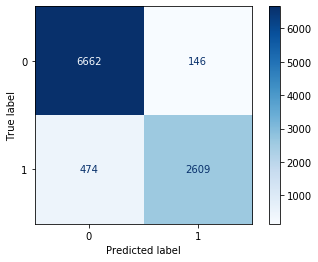

In [26]:

# View confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues');

plt.savefig("binary_confusion_matrix.png", dpi=300, bbox_inches="tight")

In [19]:
from sklearn.metrics import classification_report

In [20]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      6808
           1       0.95      0.85      0.89      3083

    accuracy                           0.94      9891
   macro avg       0.94      0.91      0.92      9891
weighted avg       0.94      0.94      0.94      9891



In [21]:
gs.best_params_

{'tvec__max_df': 0.85,
 'tvec__max_features': 10000,
 'tvec__min_df': 7,
 'tvec__ngram_range': (1, 2)}

In [27]:
from sklearn import metrics
metrics.f1_score(y_test, preds)

0.8937992463172318

In [29]:
metrics.recall_score(y_test, preds)

0.8462536490431398

In [32]:
metrics.accuracy_score(y_test, preds)

0.9373167526033768

In [31]:
metrics.precision_score(y_test, preds)

0.947005444646098

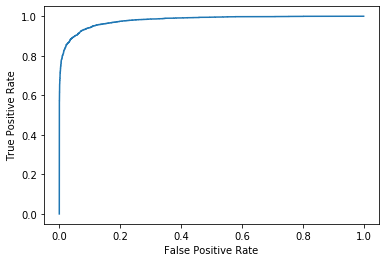

In [23]:
y_pred_prob = gs.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_prob)

# Create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

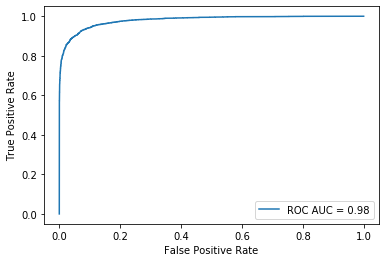

<Figure size 432x288 with 0 Axes>

In [25]:
y_pred_prob = gs.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

# Create ROC curve
plt.plot(fpr, tpr, label=f'ROC AUC = {metrics.roc_auc_score(y_test, y_pred_prob):.2f}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()  # Adding the legend
plt.show()



plt.savefig("binary_roc_curve.png", dpi=300, bbox_inches="tight")


In [39]:
# Calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9798627037394332

In [40]:
## pickle model for later use, if needed:

import pickle


# Pickle the model to a file
with open('nmb_pipe_model.pkl', 'wb') as file:
    pickle.dump(gs, file)